In [1]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import math
import openpyxl
from statistics import * 

In [11]:
#returns clean list of corrected concentrations from an excel file
def getCorrectedConcentration (file, sheet):
    wb = openpyxl.load_workbook(file)
    df = pd.read_excel(file, sheetname=sheet)
    #print(df)
    correctedConc = []
    samples = []
    for i in df.index:
        conc = df['Corrected Concentration'][i]
        samp = df[0][i]
        if isinstance(conc, float) and not math.isnan(conc): #math.isnan returns True if conc is nan
            correctedConc.append(conc)
        if samp == 'Peak#':
            sample_name = df[0][i - 1]
            clean_sample_name = sample_name[0:sample_name.index('-')]
            if clean_sample_name not in samples: samples.append(clean_sample_name)
    return [correctedConc, list(samples)]

In [12]:
#User enters data here
file = 'GCData-tdTER_mutants w Conc Data.xlsx' #file name
sheet = 'Corrected Concentration' #sheet with corrected concentration data
samples = getCorrectedConcentration(file, sheet)[1] #name of samples as they appear in the excel sheet
print('Samples in Order:', samples) #Check sample names
desired_order = ['I287A', 'WT', 'Neg'] #desired order of columns in bar chart
numVials = [3, 3, 3] ### USER INPUT number of vials per sample in order of appearance 

# Check to see if lists samples and numVials are the same length
if len(samples) != len(numVials):
    raise Exception('Length of samples and numVials lists must be the same, hoe!')

chains = ['C4','C6','C8','C10','C12','C14','C16'] #chain lenghts
title = 'TdTER in vivo screening' #graph title
ylabel = 'mg/L FaOH' #y axis label

plt.rcParams["font.family"] = "Times New Roman"


Samples in Order: ['WT', 'Neg', 'I287A']


In [13]:
#this function arranges data into an appropriate matrix. correctedConc should be clean with no empty spaces
def dataArrange(correctedConc, numTotSamples):
    numChains = int(len(correctedConc)/numTotSamples)
    correctedConc = np.array(correctedConc)
    rearranged = np.zeros((numTotSamples, numChains))
    iterator = 0;
    for sample in range(0,numTotSamples):
        for chain in range(0, numChains):
            rearranged[sample, chain] = correctedConc[iterator]
            iterator = iterator + 1 
    return rearranged.T, rearranged.T.shape

In [14]:
#Calculates average and standard deviation of data
def calcStats(data):
    stats = [mean(data), stdev(data)]
    return stats

In [15]:
#Returns average and standard deviation data in the form of matricies
def dataParse(rearranged, samples, numVials):
    #rearranged - the rearranged corrected concentration data table with each row corresponding to a chain length
        #and each column corresponding to a sample vial i.e.
        #
        #         H204A-1  H204A-2  H204A-3    WT-1    WT-2    WT-3
        #   C8 [[    #        #        #        #        #        #    ],
        #  C10  [    #        #        #        #        #        #    ],
        #  C12  [    #        #        #        #        #        #    ],
        #  C14  [    #        #        #        #        #        #    ],
        #  C16  [    #        #        #        #        #        #    ]]
        #
    #samples - list of each type of sample i.e. [H204A, WT]
    #numVials - number of vials per sample in order of appearance i.e. [3, 3]
    
    numChains = int(len(rearranged[0])) #number of chain lengths testing for
    avgMat = np.zeros((numChains, len(samples))) #matrix to store average data
    stdevMat = np.zeros((numChains, len(samples))) #matrix to store stdev data

    row_number = range(0,len(chains))
    column_number = range(0,len(samples))

    for r in row_number:
        #print(rearranged[0][r])
        for c in column_number:
            avgMat[r,c] = np.mean(rearranged[0][r][c*3:(c*3)+2]) # rearranged is an array which is set up such that each row contains the concentration for a given chain length for all samples
            stdevMat[r,c] = np.std(rearranged[0][r][c*3:(c*3)+2])
        
    return avgMat,stdevMat

In [16]:
#Creates stacked bar chart of chain length distributions
def createBarChart (file, sheet, samples, desired_order, numVials, chains, title, ylabel):
    global rearranged
    global df_avg
    global df_std
    #get concentration data from excel sheet
    concData = getCorrectedConcentration(file,sheet)[0]
    #arrange data into more managable rows and columns
    rearranged = dataArrange(concData, sum(numVials))
    
    #get mean and standard deviation data
    avgMat, stdevMat = dataParse(rearranged, samples, numVials)
    df_avg = pd.DataFrame(avgMat, columns=samples)
    df_std = pd.DataFrame(stdevMat, columns=samples)
    
    #edits column order  01/14/2021
    df_avg = df_avg[desired_order]
    df_std = df_std[desired_order]
    
    #plot data
    %matplotlib inline
    N = len(samples)
    ind = np.arange(N)
    width = 0.35
    firstMean = df_avg.loc[0,:]
    firstStd = df_std.loc[0,:]
    fistplot = plt.bar(ind, firstMean, width, yerr=firstStd, label=chains[0])
    sumMeans = [0]*len(samples)
    for chain in range(1,len(chains)):
        chainMean = df_avg.loc[chain,:]
        prevChainMean = df_avg.loc[chain-1,:]
        for i in range(len(sumMeans)):
            sumMeans[i] = sumMeans[i] + prevChainMean[i]
        chainStd = df_std.loc[chain,:]
        plt.bar(ind, chainMean, width, bottom=sumMeans, yerr=chainStd, label=chains[chain])
    plt.xticks(ind,desired_order)
    plt.legend()
    plt.suptitle(title)
    plt.ylabel(ylabel)
    plt.show

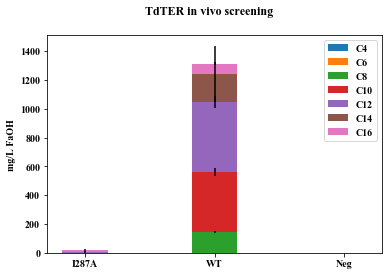

In [17]:
createBarChart(file, sheet, samples, desired_order, numVials, chains, title, ylabel)

In [31]:
rearranged[0]

array([[  2.33644924e-14,   2.48663356e-14,   2.33461693e-14,
          2.32381634e-14,   2.42126412e-14,   2.46254310e-14,
          2.33012838e-14,   2.46628465e-14,   2.31885140e-14],
       [  1.51439886e+00,   1.50445208e+00,   1.36055453e+00,
          1.37163638e-14,   1.42694018e-14,   1.45200101e-14,
          5.71981053e-03,   1.45404865e-14,   1.36793124e-14],
       [  1.50149998e+02,   1.36010879e+02,   1.38681766e+02,
          5.56597494e-01,   3.58324449e-01,   1.55201703e-12,
          1.64022663e+00,   4.69733555e-01,   1.56224892e-12],
       [  4.43873961e+02,   3.90844998e+02,   4.17302965e+02,
          1.48740016e-12,   1.24942265e-12,   1.23360888e-12,
          1.67783461e-12,   1.33116648e-12,   1.29443285e-12],
       [  5.26470853e+02,   4.44327191e+02,   5.14089783e+02,
          6.97595748e-13,   6.05821700e-13,   5.86094115e-13,
          8.85145747e+00,   6.45803978e-13,   6.20485737e-13],
       [  3.91361900e+02,   7.55386191e-13,   3.68918498e+02,
   

In [32]:
df_avg

,WT,Neg,I287A
0,2.411541e-14,2.372540e-14,2.398207e-14
1,1.509425e+00,1.399288e-14,2.859905e-03
2,1.430804e+02,4.574610e-01,1.054980e+00
3,4.173595e+02,1.368411e-12,1.504501e-12
4,4.853990e+02,6.517087e-13,4.425729e+00
5,1.956810e+02,6.255287e-13,6.371361e-01
6,7.128494e+01,4.212670e-01,1.042179e+01


In [33]:
df_std

,WT,Neg,I287A
0,7.509216e-16,4.872389e-16,6.807813e-16
1,4.973389e-03,2.765190e-16,2.859905e-03
2,7.069560e+00,9.913652e-02,5.852465e-01
3,2.651448e+01,1.189888e-13,1.733341e-13
4,4.107183e+01,4.588702e-14,4.425729e+00
5,1.956810e+02,2.350051e-14,6.371361e-01
6,9.090584e+00,3.570773e-02,9.990201e+00
